In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline
plt.style.use('ggplot')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import _tree
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import GradientBoostingRegressor

In [8]:
data = pd.read_csv('data/OnlineNewsPopularity.csv')

In [9]:
y = data[' shares'].values
X = data.drop([' shares','url',' timedelta'], axis = 1).values

In [10]:
def get_tree_oob_score(tree,X_train,y_train):
    #gets the oob score for the given tree
    indicies = _generate_unsampled_indices(tree.random_state, X_train.shape[0])
    y_true = y_train[indicies]
    y_hat_tree = tree.predict(X_train[indicies])
    rmse = np.sqrt(np.sum((y_true - y_hat_tree)**2)/len(indicies))
    return rmse

def get_score_with_x_trees(x,predictions, y_val):
    #gets the RMSE for the top x trees in the list 
    predictions = predictions[:x]
    y_hat = predictions.mean(axis = 0)
    rmse = np.sqrt(np.mean((y_val - y_hat)**2))
    return rmse


In [100]:
def get_scores(X,y, max_features = 'sqrt',max_depth = 4):
    forest = RandomForestRegressor(n_estimators= 1000, max_depth= max_depth,
                                   n_jobs= -1, oob_score= True, max_features = max_features,
                                   bootstrap= True, min_samples_leaf= 4 )

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    forest.fit(X_train,y_train)

    y_test_hat = forest.predict(X_test)

    #rmse of the entire model
    full_model_rmse = np.sqrt( np.mean( ((y_test - y_test_hat)**2)  ) )

    
    trees = forest.estimators_
    
    random_trees = trees.copy()
    #the oob scores used to evaluate the trees 
    oob_scores = [get_tree_oob_score(tree,X_train,y_train) for tree in trees]
    

    #trees ordered by their oob scores
    tree_inds = np.argsort(oob_scores)
    ordered_trees = [trees[i] for i in tree_inds]
    
    ordered_tree_preds = np.array([tree.predict(X_test) for tree in ordered_trees])  
    
    #trees randomly ordered
    random_tree_preds = np.array([tree.predict(X_test) for tree in random_trees])
    
    #this gets the score for the best x trees for x from 1 to 1000   
    scores = []
    for x in range(1,1001):
        scores.append(get_score_with_x_trees(x,ordered_tree_preds,y_test))
    #this gets the score for a random x trees from 1 to 1000 as a null hypothesis
    random_scores = []
    for x in range(1,1001):
        random_scores.append(get_score_with_x_trees(x,random_tree_preds,y_test))

    
    return (full_model_rmse, scores ,random_scores)

In [101]:
def run_experiment(num_models, X,y,max_features = 'sqrt'):
    results = []
    t1 = time.time()
    for x in range(0,num_models):
        results.append(get_scores(X,y,max_features= max_features))
        if x%10 == 0:
            print("{}/{} done in {} seconds".format(x+1,num_models,time.time() - t1))
    return results

In [112]:
def plot_results(results_list, xlims, ylims,gberrors = []):
    fig, axs = plt.subplots(ncols=len(results_list), nrows = 3, figsize = (10*len(results_list),30))
    for i,results in enumerate(results_list):
        for total, scores, random_scores in results:
            axs[0][i].plot([x for x in range(1,1001)], [s - total  for s in scores], 'b', alpha = 0.1)
            axs[1][i].plot([x for x in range(1,1001)], [s - total  for s in random_scores], 'r', alpha = 0.1)
            axs[0][i].hlines(0,0,1000,color = 'g',alpha = .8)
            axs[1][i].hlines(0,0,1000,color = 'g',alpha = .8)

        average_ordered, average_random = [],[]    
        for x in range(0,1000):
            ordered,rand = [],[]
            for total,o_scores,r_scores in results:
                ordered.append(o_scores[x] - total)
                rand.append(r_scores[x] - total)
            average_ordered.append(np.mean(ordered))
            average_random.append(np.mean(rand))
        axs[0][i].plot([x for x in range(1,1001)],average_ordered,'b',alpha = .8)        
        axs[1][i].plot([x for x in range(1,1001)],average_random, 'r', alpha = 0.8)

        axs[2][i].plot([x for x in range(1,1001)],average_ordered,'b',alpha = .8)        
        axs[2][i].plot([x for x in range(1,1001)],average_random, 'r', alpha = 0.8)

        if gberrors:
            total_average = np.mean([r[0] for r in results])
            for gbe in gberrors:
                axs[2].hlines( gbe - total_average ,0,1000,color='m',alpha = .3)
            axs[2].hlines(np.mean(gberrors),0,1000,color='m',alpha = .8)
        axs[2][i].hlines(0,0,1000,color = 'g',alpha = .8)
        axs[0][i].set_ylim(ylims[0],ylims[1])   
        axs[0][i].set_xlim(xlims[0],xlims[1])
        axs[1][i].set_ylim(ylims[0],ylims[1])    
        axs[1][i].set_xlim(xlims[0],xlims[1])
        axs[2][i].set_ylim(ylims[0],ylims[1])   
        axs[2][i].set_xlim(xlims[0],xlims[1])

    plt.show()

In [19]:
results = run_experiment(20,X,y)   

27.17058038711548
52.86729335784912
78.79142022132874
106.88051652908325
144.3772256374359
186.6091070175171
228.06371665000916
269.8035762310028
310.48039507865906
352.05652117729187
393.333801984787
421.05278301239014
447.2460927963257
472.8819544315338
498.7811176776886
524.5213260650635
550.4783737659454
576.1006367206573
601.747889995575
627.3530805110931


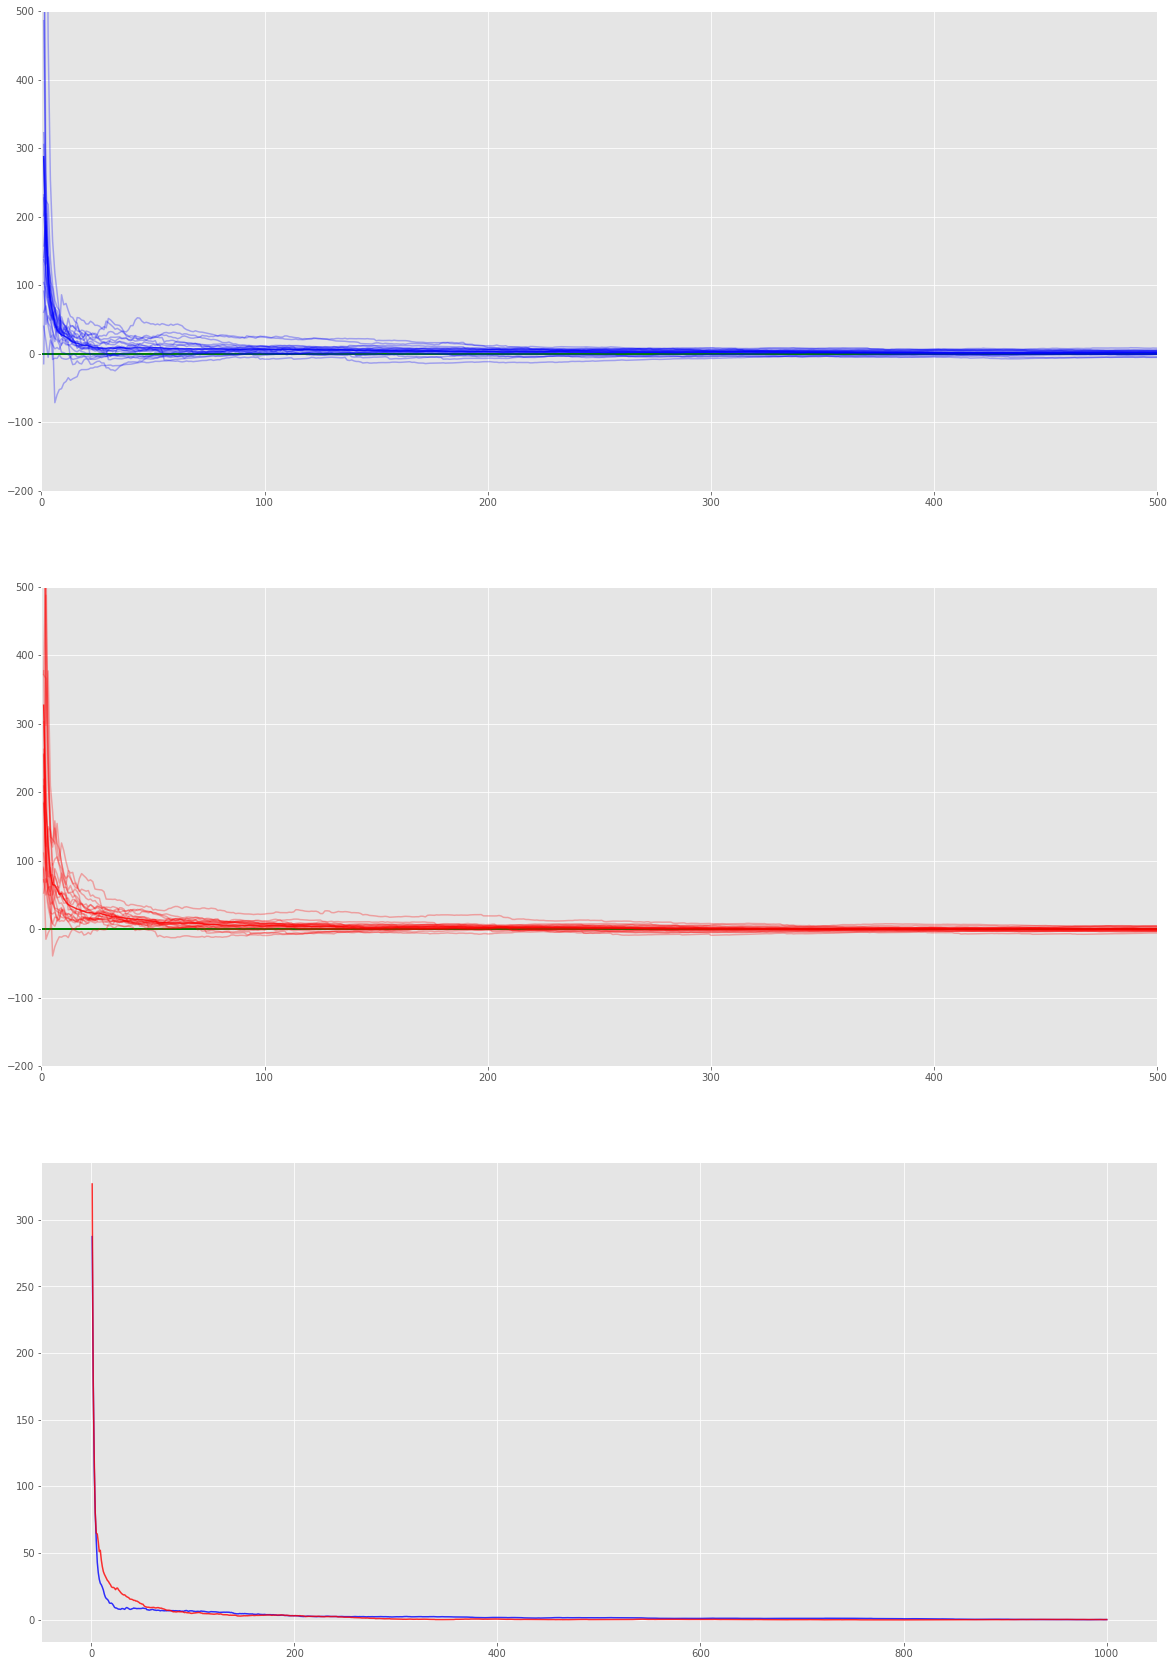

In [26]:
plot_results(results,(0,500),(-200,500))

In [4]:
data2 = pd.read_csv('data/slump_test.data.csv',index_col='No')

In [35]:
data2.shape

(103, 10)

In [7]:
X2,y2 = data2.drop('Compressive Strength (28-day)(Mpa)', axis = 1).values,data2['Compressive Strength (28-day)(Mpa)'].values

In [103]:
results2c = run_experiment(100,X2,y2,max_features=None)
results2a = run_experiment(100,X2,y2,max_features='log2')
results2b = run_experiment(100,X2,y2,max_features='sqrt')


1/100 done in 1.349837064743042 seconds
11/100 done in 14.872730016708374 seconds
21/100 done in 27.529003620147705 seconds
31/100 done in 41.05575394630432 seconds
41/100 done in 54.76913404464722 seconds
51/100 done in 68.18930220603943 seconds
61/100 done in 80.2516176700592 seconds
71/100 done in 92.30407238006592 seconds
81/100 done in 104.29728817939758 seconds
91/100 done in 116.26136517524719 seconds
1/100 done in 1.2030935287475586 seconds
11/100 done in 13.178669452667236 seconds
21/100 done in 25.14697027206421 seconds
31/100 done in 37.093040466308594 seconds
41/100 done in 49.08014631271362 seconds
51/100 done in 61.207359790802 seconds
61/100 done in 73.98543310165405 seconds
71/100 done in 85.8383538722992 seconds
81/100 done in 97.84206986427307 seconds
91/100 done in 110.55099487304688 seconds
1/100 done in 1.6059317588806152 seconds
11/100 done in 16.245281219482422 seconds
21/100 done in 29.091537475585938 seconds
31/100 done in 41.575560331344604 seconds
41/100 done

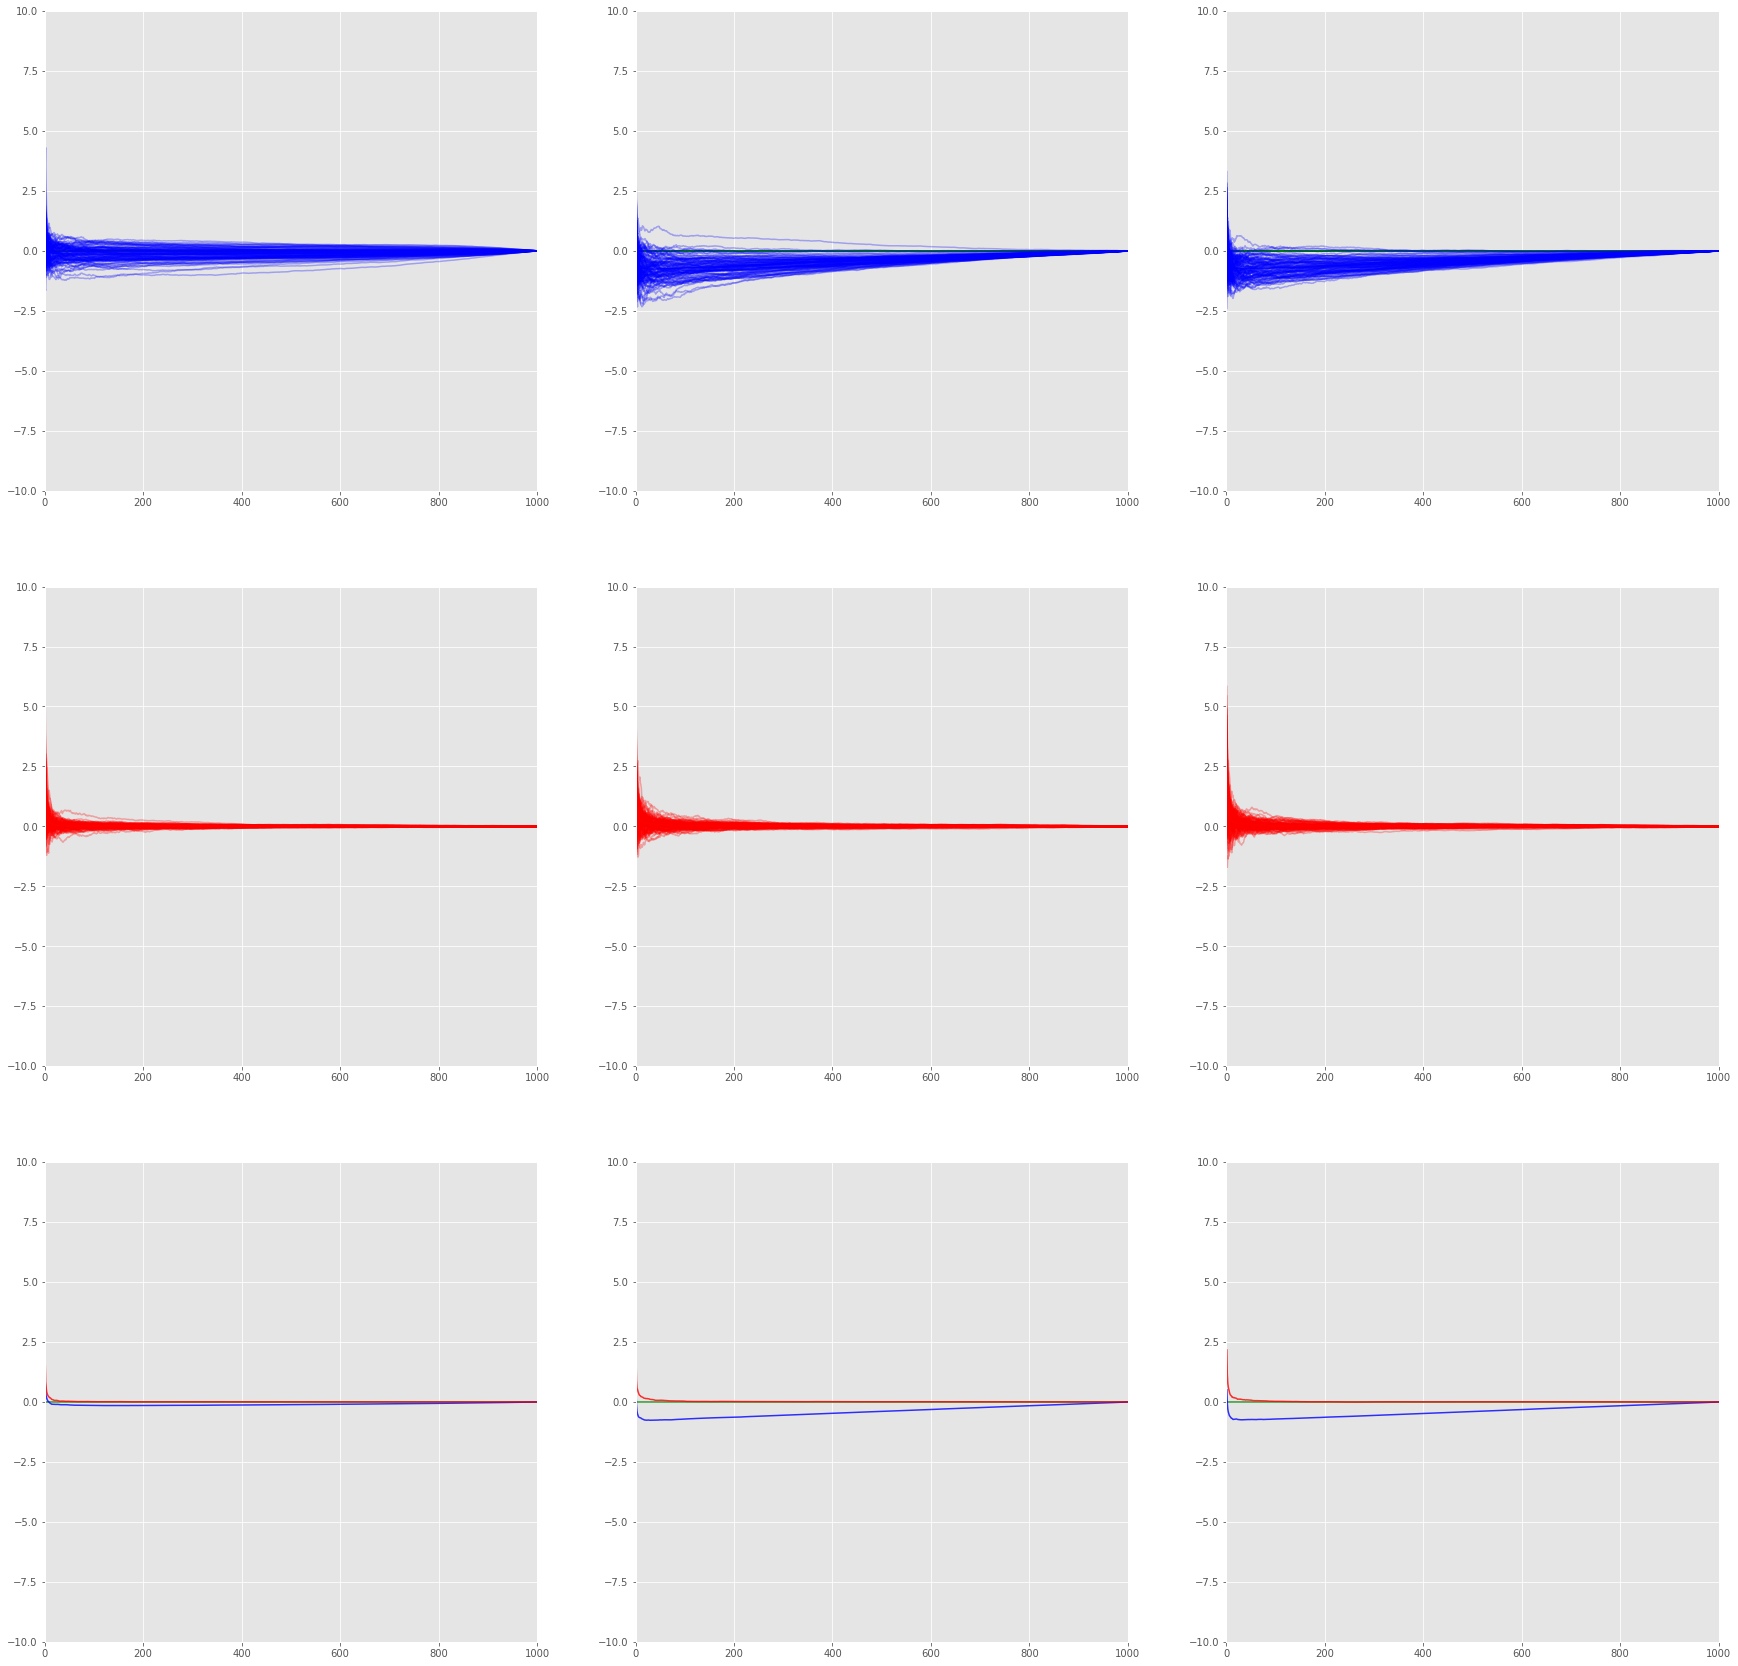

In [110]:
plot_results([results2c,results2a,results2b],(0,1000),(-10,10))

In [ ]:
plot_results(results2b,(0,1000),(-10,10))

In [34]:
min_ordereds, min_randoms, compared_ordered, compared_random = [],[],[],[]
for total, scores, random_scores in results:
    min_scores = np.argmin(scores)
    min_ordereds.append(min_scores)
    compared = total - min(scores)
    compared_ordered.append(compared)
    min_random = np.argmin(random_scores)
    min_randoms.append(min_random)
    compared= total - min(random_scores)
    compared_random.append(compared)

In [53]:
def train_gradient_boosters(n,X,y,n_estimators = 1000):
    #trains a bunch of gradient boosting classifiers 
    errors = []
    for i in range(0,n):
        gbr = GradientBoostingRegressor(n_estimators=n_estimators,learning_rate=.001,max_depth=3,subsample=.5,max_features = None)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        gbr.fit(X_train,y_train)
        y_hat = gbr.predict(X_test)
        rmse = np.sqrt( np.mean( (y_test - y_hat)**2))
        errors.append(rmse)
    return errors

In [98]:
gberrors2 = train_gradient_boosters(10,X2,y2)

In [81]:
# this data has only categorical variables so we can see that effect
data3 = pd.read_csv('data/flare.data2.csv',header=None, delimiter = ' ')

In [72]:
data3.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,H,A,X,1,3,1,1,1,1,1,0,0,0
1,D,R,O,1,3,1,1,2,1,1,0,0,0
2,C,S,O,1,3,1,1,2,1,1,0,0,0
3,H,R,X,1,2,1,1,1,1,1,0,0,0
4,H,S,X,1,1,1,1,2,1,1,0,0,0


In [83]:
X3 = pd.get_dummies(data3,columns=[0,1,2,3,4,5,6,7,8,9]).drop([10,11,12], axis = 1).values
y3 = data3[10].values

In [107]:
features = [None,'sqrt','log2']
results3 = [run_experiment(100,X3,y3,f) for f in features]


1/100 done in 1.4612696170806885 seconds
11/100 done in 17.27270793914795 seconds
21/100 done in 32.89311218261719 seconds
31/100 done in 49.44717073440552 seconds
41/100 done in 65.65298891067505 seconds
51/100 done in 82.89200234413147 seconds
61/100 done in 98.61296653747559 seconds
71/100 done in 114.56080770492554 seconds
81/100 done in 130.02975225448608 seconds
91/100 done in 144.61103677749634 seconds
1/100 done in 1.3212203979492188 seconds
11/100 done in 14.729801893234253 seconds
21/100 done in 28.00455927848816 seconds
31/100 done in 41.407137393951416 seconds
41/100 done in 54.74408531188965 seconds
51/100 done in 68.40242505073547 seconds
61/100 done in 81.84002208709717 seconds
71/100 done in 95.22845840454102 seconds
81/100 done in 108.61866903305054 seconds
91/100 done in 123.73106932640076 seconds
1/100 done in 1.7099628448486328 seconds
11/100 done in 18.274125814437866 seconds
21/100 done in 33.07688307762146 seconds
31/100 done in 47.44416666030884 seconds
41/100 d

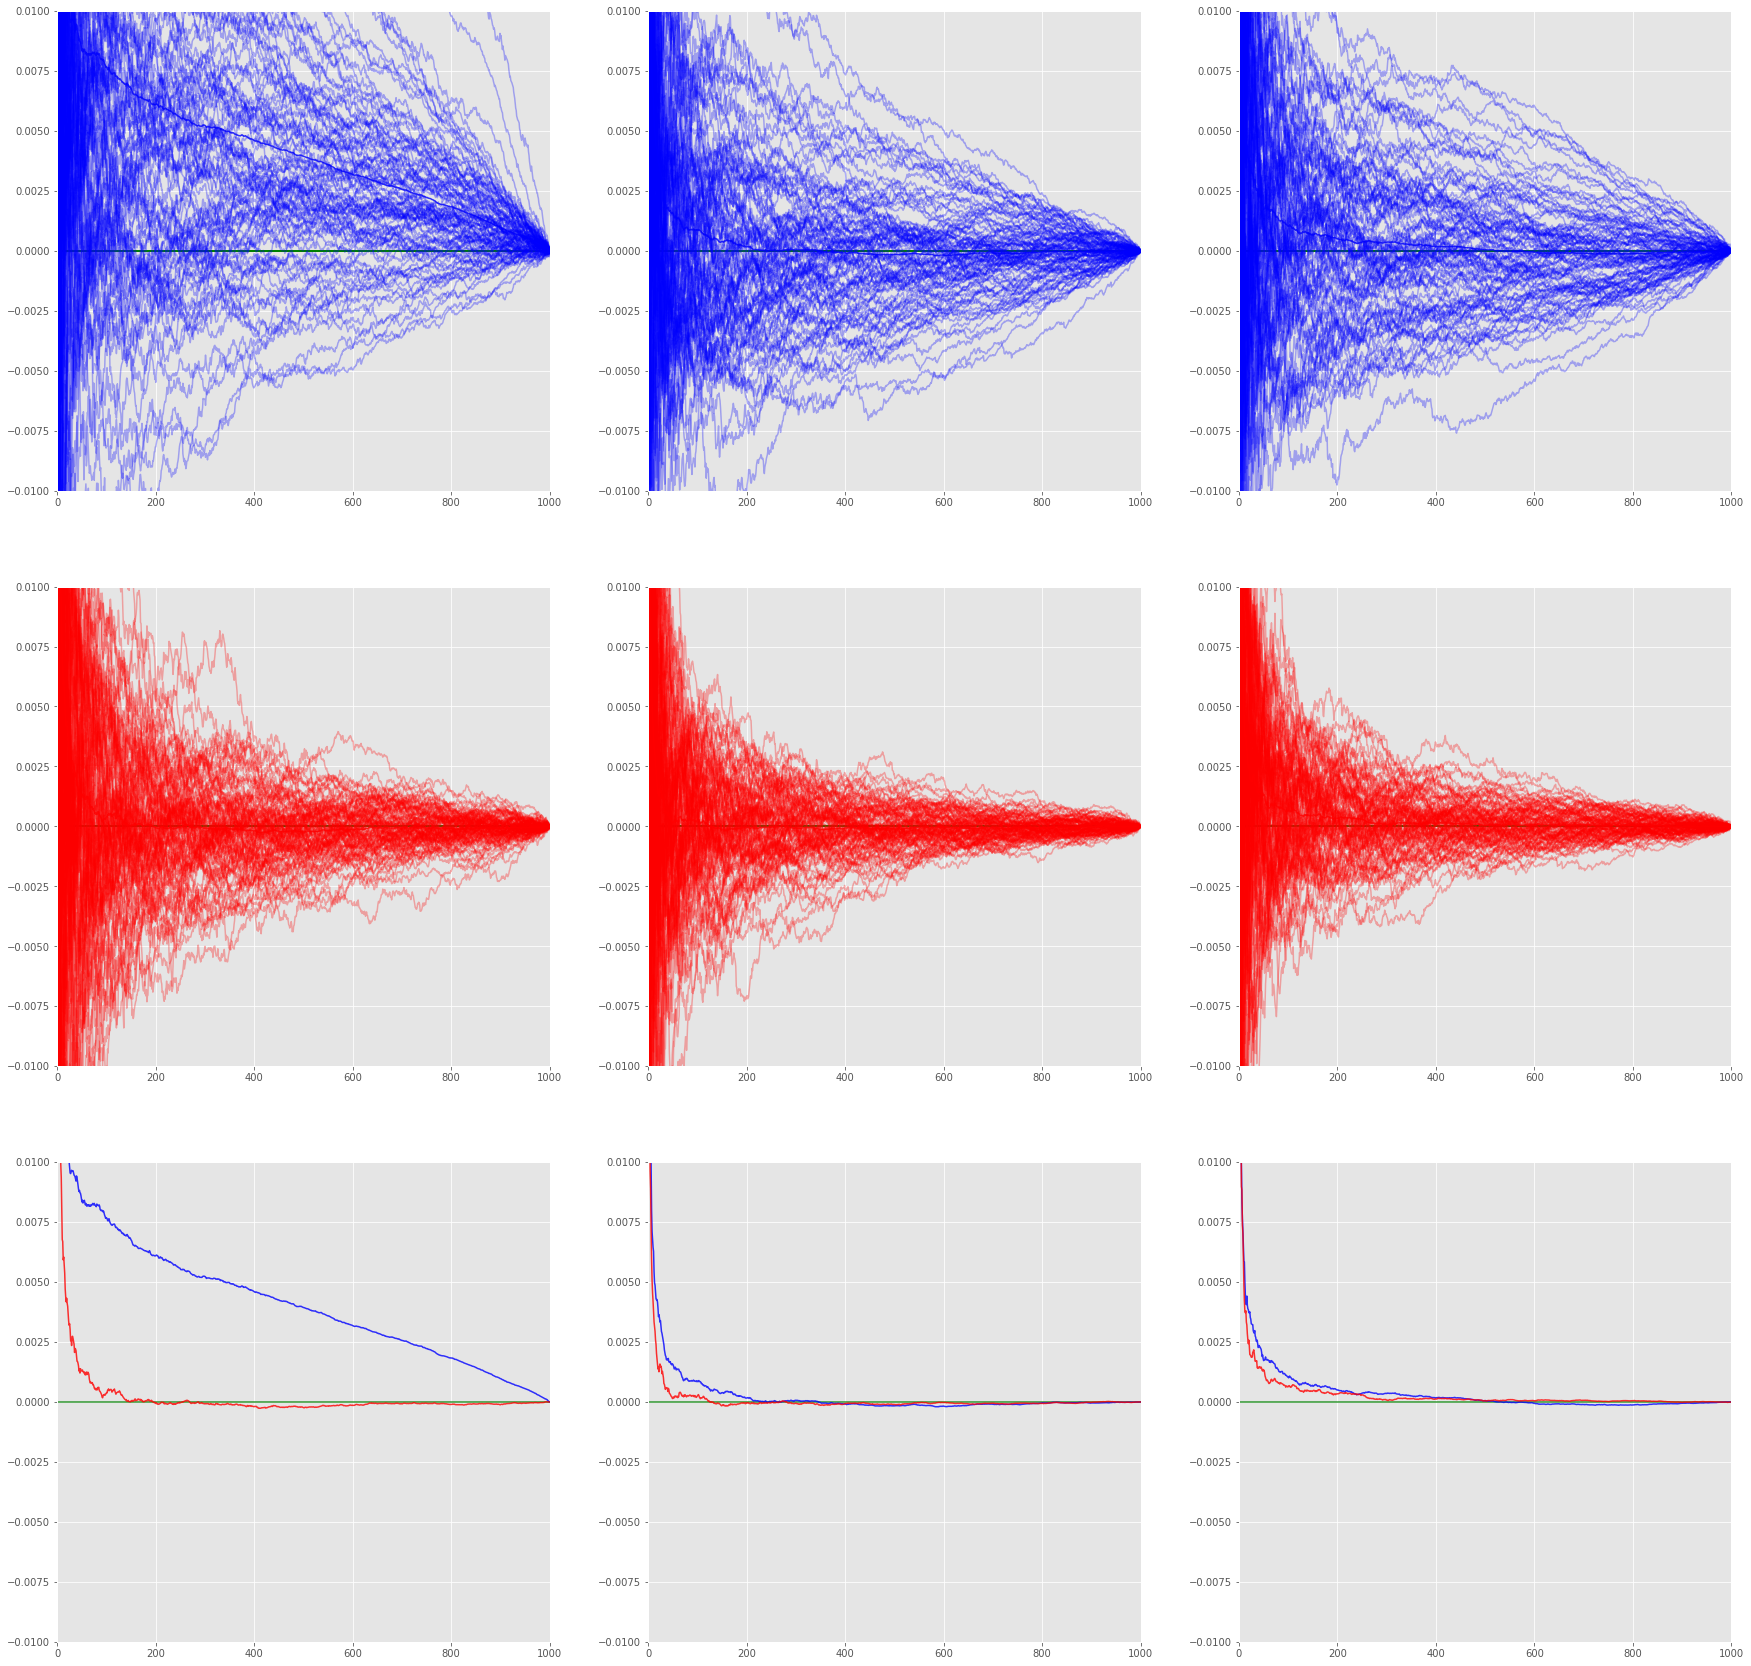

In [111]:
plot_results(results3,(0,1000),(-.01,.01))

[0.65228242316905982, 0.83671297588028226, 0.85457789750858937, 0.76975996137617519, 0.84959440294220434, 0.77247018482361862, 0.77589610827924005, 0.76087722279592573, 0.71281850350494391, 0.75108162215347363]
